In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#Imports
import fileinput
import numpy as np
import pandas as pd
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.core import Dense, Dropout
from keras.models import Sequential
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


#z-score Feature normalization - A z-score measures exactly how many standard deviations above or below the mean a data point is
def feature_normalize(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma


#removes semicolons from input data
def removeSemiCol():
    num_lines = 0
    folder_path = "/content/drive/My Drive/Colab/Statistical Learning/Project/Dataset/wisdm-dataset/raw/phone/accel/"
    for i in range(50):
        # print(i)
        if i <= 9:
            with fileinput.FileInput(folder_path + "data_160" + str(i) + "_accel_phone.txt", inplace=True,
                                     backup='.bak') as file:
                num_lines = num_lines + sum(1 for line in open(folder_path + "data_160" + str(i) + "_accel_phone.txt"))
                for line in file:
                    print(line.replace(";", ""), end='')
        else:
            with fileinput.FileInput(folder_path + "data_16" + str(i) + "_accel_phone.txt", inplace=True,
                                     backup='.bak') as file:
                num_lines = num_lines + sum(1 for line in open(folder_path + "data_16" + str(i) + "_accel_phone.txt"))

                for line in file:
                    print(line.replace(";", ""), end='')

    print(num_lines)

#load data from txt file to panda frame
def loadData():
    folder_path = "/content/drive/My Drive/Colab/Statistical Learning/Project/Dataset/wisdm-dataset/raw/phone/accel/"
    column_names = ['user-id', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
    li = []
    for i in range(50):
        # print(i)
        if i <= 0:
            df = pd.read_csv(folder_path + "data_160" + str(i) + "_accel_phone.txt", header=None, names=column_names)
            li.append(df)
        else:
            a = 1
            # data = pd.read_csv(folder_path + "data_16" + str(i) + "_accel_phone.txt", header=None, names=column_names)
            # li.append(data)

    df = pd.concat(li, axis=0, ignore_index=True)

    y = df.activity

    x = df.drop(['activity', 'user-id'], axis=1)

#Data preprocessing
#CNN model expects fixed-length sequences as training data.
# Each generated sequence will contain 200 training steps
    RANDOM_SEED = 42
    N_TIME_STEPS = 200
    N_FEATURES = 3
    step = 20
    segments = []
    labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
        xs = df['x-axis'].values[i: i + N_TIME_STEPS] # Ith position to 200 records pf X-axis
        ys = df['y-axis'].values[i: i + N_TIME_STEPS] # Ith position to 200 records pf Y-axis
        zs = df['z-axis'].values[i: i + N_TIME_STEPS] # Ith position to 200 records pf Y-axis
        label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0] # In current 200 records which label occurs the most is taken
        segments.append([xs, ys, zs])
        labels.append(label)
    
    print("Segments : "+str(len(segments)))
    print("Labels : "+str(len(labels)))
    
    # we know CNN accepts 3D array we convert 1d array to 3d
    
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
    print("reshaped_segment : "+str(reshaped_segments.shape))

    #reshape the output variable to 2d
    labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)
    print("labels : "+str(labels.shape))

    #Train  and test data split
    X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

    return X_train, y_train, X_test, y_test, df

#This function return no of output class (18 activities)
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

#Main function
if __name__ == "__main__":
    # removeSemiCol()
    X_train, y_train, X_test, y_test, data = loadData()
    
    #Assign model parameters 
    timesteps = len(X_train[0]) #no of records 200 
    input_dim = len(X_train[0][0]) #no of features
   

    print(timesteps)
    print(input_dim)
   
    

    #CNN Model defination  
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu',input_shape=(timesteps, input_dim)))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(Dropout(0.6))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(18, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    #Training input data
    history = model.fit(X_train,y_train, epochs=30, batch_size=20,validation_data=(X_test, y_test), verbose=1)
    

Using TensorFlow backend.


Segments : 3206
Labels : 3206
reshaped_segment : (3206, 200, 3)
labels : (3206, 18)
200
3




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 198, 16)           160       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 196, 32)           1568      
_________________________________________________________________
dropout_1 (Dropout)          (None, 196, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
________________________________________

/content
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


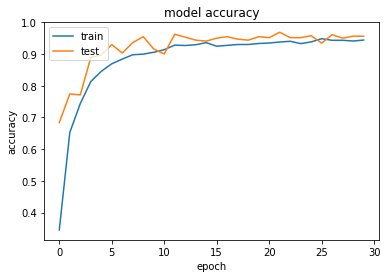

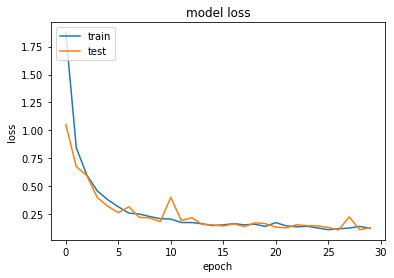

In [4]:
    !pwd
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("/content/drive/My Drive/Colab/Research Topics/Final Project/Model Accuracy.jpg")
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("/content/drive/My Drive/Colab/Research Topics/Final Project/Model Loss.jpg")
    plt.show()